In [4]:
import numpy as np
import matplotlib.pyplot as plt
import utils.mnist_reader as mnist_reader

In [5]:
x_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
x_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')
x_train.shape

(60000, 784)

In [6]:
y_train.shape


(60000,)

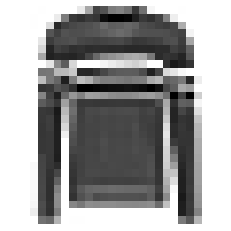

In [7]:
some_digit = x_train[5]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [8]:
y_train[5]

2

In [9]:
y_train = y_train.astype(np.uint8)

In [10]:
y_train_2 = (y_train == 2)  # True for all 2s, False for all other digits JUST SHIRTS
y_test_2 = (y_test == 2)

### "Use SGDClassifier"

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_2)
sgd_clf.predict([some_digit]) #interesting.. that was supposed to be true

array([False])

### "Use StratifiedKFold cross validation"

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(x_train, y_train_2):
    clone_clf = clone(sgd_clf)
    x_train_folds = x_train[train_index]
    y_train_folds = y_train_2[train_index]
    x_test_fold = x_train[test_index]
    y_test_fold = y_train_2[test_index]

    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9381
0.91735
0.9284


### "Use StratifiedKFold cross validation"

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train, y_train_2, cv=3, scoring="accuracy")


array([0.9345 , 0.93565, 0.91235])

In [14]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_2, cv=3)

### "Generate a confusion matrix"

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_2, y_train_pred) 
# The results show that in the negative class 51813 were correctly classified. The remaining 2187 were incorrectly classified.
# Additionally, in the positive class, 2163 were incorrectly classified as non-2s and 3837 were correctly classified as 2s
# Read as:
# true neg, false pos
# false neg, true pos

array([[51813,  2187],
       [ 2163,  3837]], dtype=int64)

### "Use k-fold Cross Validation"

In [16]:
y_scores = cross_val_predict(sgd_clf, x_train, y_train_2, cv=3, method="decision_function")

### "Generate a ROC curve or related"

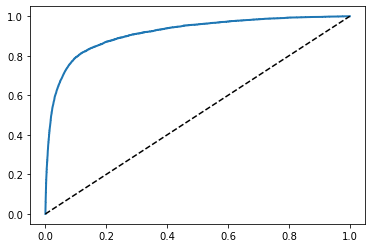

In [17]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_2, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
plot_roc_curve(fpr,tpr)
plt.show()

### "Use sklearn.ensamble.RandomForestClassifier

In [18]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_2, cv=3,
                                    method="predict_proba")

In [19]:
y_scores_forest = y_probas_forest[:, 1]   # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_2,y_scores_forest)

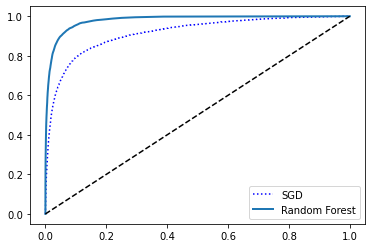

In [20]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

### "Use OvO or OvR classifier" (Chose to use OvR)

In [21]:
from sklearn.multiclass import OneVsRestClassifier 
from sklearn.svm import SVC

In [23]:
svm_clf = SVC()
svm_clf.fit(x_train, y_train)
svm_clf.predict([some_digit]) # Using OvO strategy


array([2], dtype=uint8)

In [24]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 6.23967633,  2.74790373,  9.31663366,  3.78943336,  7.29085442,
         1.71424807,  8.29185535, -0.31020142,  4.89359543,  0.69515658]])

In [28]:
svm_clf.classes_ # Class 2 did the best out of the classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

### "Scale/normalize/standardize features using sklearn.preprocessing" 

In [35]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
# cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring="accuracy")

In [36]:
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

C:\Users\Owner\anaconda3\envs\mlenvPy3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Owner\anaconda3\envs\mlenvPy3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Owner\anaconda3\envs\mlenvPy3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([[4777,   19,   88,  448,   26,    1,  550,    0,   91,    0],
       [  14, 5685,   38,  199,   15,    1,   45,    0,    3,    0],
       [  42,    5, 4367,   90,  772,    0,  663,    0,   61,    0],
       [ 212,  105,   76, 5205,  191,    0,  199,    0,   12,    0],
       [   8,    5,  617,  330, 4449,    0,  568,    0,   23,    0],
       [   4,    2,    3,   11,    2, 5489,   18,  277,   72,  122],
       [ 806,   18,  635,  372,  550,    0, 3441,    1,  176,    1],
       [   0,    0,    0,    0,    0,  319,    0, 5422,   16,  243],
       [  31,    3,   28,  121,   33,   11,  138,   35, 5595,    5],
       [   0,    0,    0,    6,    1,  100,    7,  251,    4, 5631]],
      dtype=int64)

### "Scale/normalize/standardize features using sklearn.preprocessing"

In [45]:
x_test.shape
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_test_scaled = scaler.fit_transform(x_test.astype(np.float64))
# cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring="accuracy")

In [46]:
y_test_pred = cross_val_predict(sgd_clf, x_test_scaled, y_test, cv=3)
conf_mx = confusion_matrix(y_test, y_test_pred)
conf_mx

array([[759,   5,  24,  76,   4,   0, 112,   0,  20,   0],
       [  4, 941,  10,  31,   7,   0,   6,   0,   1,   0],
       [ 14,   2, 696,  25, 145,   0, 106,   0,  12,   0],
       [ 41,  23,  14, 830,  33,   0,  56,   0,   2,   1],
       [  1,   2, 131,  60, 707,   0,  97,   0,   2,   0],
       [  2,   1,   0,   0,   0, 884,   0,  58,  18,  37],
       [143,   2, 132,  79, 118,   0, 493,   1,  32,   0],
       [  0,   0,   0,   0,   0,  65,   0, 884,   3,  48],
       [ 10,   1,   5,  21,   3,   3,  20,   8, 928,   1],
       [  0,   0,   0,   2,   0,  21,   2,  46,   0, 929]], dtype=int64)

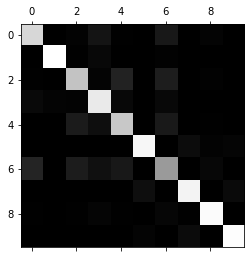

In [37]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

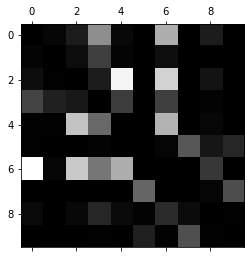

In [38]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

### "Use sklearn.neighbors.KNeighborsClassifier"

In [39]:
from sklearn.neighbors import KNeighborsClassifier
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)


KNeighborsClassifier()

In [40]:
knn_clf.predict([some_digit])

array([[2, 0]], dtype=uint8)